In [1]:
import numpy as np
from jonigrad.layers import *

In [2]:
class MultiHeadAttention(Module):
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = Linear(d_model, d_model)
        self.wk = Linear(d_model, d_model)
        self.wv = Linear(d_model, d_model)

        self.attention = ScaledDPAttention(self.depth)

        self.linear = Linear(d_model, d_model)
        self.norm = LayerNorm((d_model,))

    def split_heads(self, x, batch_size):
        x = x.reshape(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)

    def combine_heads(self, x, batch_size):        
        x = x.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)
        return x
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]
        
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        scaled_attention, _ = self.attention.forward(q, k, v, mask)
        scaled_attention = self.combine_heads(scaled_attention, batch_size)
        
        output = self.linear(scaled_attention)
        return self.norm(output + self.combine_heads(q, batch_size))  

    def backward(self, dL_dy):
        batch_size = dL_dy.shape[0]
        
        # Gradient of the norm layer
        dL_dnorm = self.norm.backward(dL_dy)

        # Gradient through the final linear layer
        dL_dlinear = self.linear.backward(dL_dnorm)

        # Reshape back to split heads format
        dL_dlinear_heads = self.split_heads(dL_dlinear, batch_size)
        
        # Gradient through attention mechanism
        dL_dattn_q, dL_dattn_k, dL_dattn_v = self.attention.backward(dL_dlinear_heads)
        
        # Gradient through the input projections
        dL_dq = self.wq.backward(self.combine_heads(dL_dattn_q, batch_size))
        dL_dk = self.wk.backward(self.combine_heads(dL_dattn_k, batch_size))
        dL_dv = self.wv.backward(self.combine_heads(dL_dattn_v, batch_size))
        
        return dL_dq, dL_dk, dL_dv

class ScaledDPAttention(Module):
    def __init__(self, depth):
        super().__init__()
        self.scale = np.sqrt(depth)
        self.softmax = Softmax()
    
    def forward(self, q, k, v, mask=None):
        self.q, self.k, self.v = q, k, v
        self.mask = mask

        self.scores = np.matmul(q, k.transpose(0, 1, 3, 2)) / self.scale
        if mask is not None:
            self.mask = mask[:, :, :self.scores.shape[-2], :self.scores.shape[-1]]
            self.scores = np.where(self.mask, self.scores, -1e9)
            
        self.attn = self.softmax(self.scores)
        self.output = np.matmul(self.attn, v)
        return self.output, self.attn
    
    def backward(self, dL_dy):
        # Gradient of the output wrt. attention weights
        dL_dattn = np.matmul(dL_dy, self.v.transpose(0, 1, 3, 2))
        
        # Gradient of the output wrt. v
        dL_dv = np.matmul(self.attn.transpose(0, 1, 3, 2), dL_dy)
        
        # Backward pass through softmax
        datt_scores = self.softmax.backward(dL_dattn)
        
        if self.mask is not None:
            datt_scores = np.where(self.mask, datt_scores, 0)

        # Gradients of the scores wrt. q, k
        dL_dq = np.matmul(datt_scores, self.k) / self.scale
        dL_dk = np.matmul(datt_scores.transpose(0, 1, 3, 2), self.q) / self.scale


        return dL_dq, dL_dk, dL_dv

class LinearLayer(Module):
    def __init__(self, d_model=512, seq_len=100):
        super().__init__()
        self.fc1 = Linear(d_model, d_model*2)
        self.relu = ReLU()
        self.fc2 = Linear(d_model*2, d_model)
        self.norm = LayerNorm((d_model,))

    def forward(self, x):
        self.residual = x
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        self.out = self.norm(x + self.residual)
        return self.out

    def backward(self, dL_dy):
        # Gradient of the normalization layer
        dL_dnorm = self.norm.backward(dL_dy)

        # Split the gradient at the addition operation
        dL_dresidual = dL_dnorm  # Gradient through the residual connection
        dL_dfc2_input = dL_dnorm  # Gradient through the output of fc2

        # Gradient through the second linear layer
        dL_dfc2 = self.fc2.backward(dL_dfc2_input)

        # Gradient through the ReLU activation
        dL_drelu = self.relu.backward(dL_dfc2)

        # Gradient through the first linear layer
        dL_dfc1 = self.fc1.backward(dL_drelu)

        # Combine gradients from the residual and the main path
        dL_dx = dL_dfc1 + dL_dresidual
        
        return dL_dx


def create_look_ahead_mask(size):
    mask = np.triu(np.ones((size, size)), k=1)  # Upper triangular matrix with a shift
    return mask != 1  # Convert to boolean mask

def create_padding_mask(seq):
    mask = (seq != 0)
    return mask[:, np.newaxis,:, np.newaxis]

def shift_right(x):
    zero_col = np.zeros((x.shape[0], 1, x.shape[2]))  # Shape (batch_size, 1, d_model)
    return np.concatenate([zero_col, x[:, :-1, :]], axis=1)

class TransformerDecoder(Module):
    def __init__(self, vocab_size=1000, d_model=512, num_heads=8, seq_len=10):
        super().__init__()
        self.num_heads = num_heads
        self.input_embedding = Embedding(vocab_size, d_model)
        self.positional_embedding = Embedding(seq_len, d_model)
        self.masked_multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.linear_layer = LinearLayer(d_model, seq_len)
        self.final_linear = Linear(d_model, vocab_size)
        
    def forward(self, x, k, v):
        batch_size, seq_len = x.shape
        
        look_ahead_mask = create_look_ahead_mask(seq_len)
        padding_mask = create_padding_mask(x)

        pos = np.tile(np.arange(seq_len), (batch_size, 1))
        x = self.input_embedding(x)
        x = shift_right(x)
        x += self.positional_embedding(pos)
        
        x = self.masked_multi_head_attention(x, x, x, look_ahead_mask[np.newaxis, np.newaxis, :, :])

        x = self.multi_head_attention(x, k, v, padding_mask)
        
        x = self.linear_layer(x)
        
        logits = self.final_linear(x)

        return logits

    def backward(self, dL_dy):
        # Backpropagate through the softmax and final linear layer
        # dL_dlogits = self.softmax.backward(dL_dy)
        dL_dlinear = self.final_linear.backward(dL_dy)
        
        # Backpropagate through the linear layer
        dL_dlinear_layer = self.linear_layer.backward(dL_dlinear)
        
        # Split the gradients for the multi-head attention
        dL_dmh_attention = dL_dlinear_layer
        
        # Backpropagate through the multi-head attention with encoder output
        dL_dmh_attention, dL_dk, dL_dv = self.multi_head_attention.backward(dL_dmh_attention)

        dL_dmh_self_attention, _, _ = self.masked_multi_head_attention.backward(dL_dmh_attention)

        dL_dx = dL_dmh_self_attention
        
        return dL_dx, dL_dk, dL_dv


class TransformerEncoder(Module):
    def __init__(self, vocab_size=1000, d_model=512, num_heads=8, seq_len=10):
        super().__init__()
        self.d_model = d_model
        self.input_embedding = Embedding(vocab_size, d_model)
        self.positional_embedding = Embedding(seq_len, d_model)
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.linear_layer = LinearLayer(d_model, seq_len)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        pos = np.tile(np.arange(seq_len), (batch_size, 1))
        padding_mask = create_padding_mask(x)
        x = self.input_embedding(x) * np.sqrt(self.d_model)  # Scale embedding
        x += self.positional_embedding(pos)

        x = self.multi_head_attention(x, x, x, padding_mask)
        x = self.linear_layer(x)
        return x

    def backward(self, dL_dy):
        # Backpropagate through the linear layer
        dL_dlinear = self.linear_layer.backward(dL_dy)
        
        # Backpropagate through multi-head attention
        dL_dattn_q, dL_dattn_k, dL_dattn_v = self.multi_head_attention.backward(dL_dlinear)
        
        dL_dx = dL_dattn_q
        return dL_dx


In [3]:
vocab_size1 = 12
vocab_size2 = 13
seq_len1 = 5
seq_len2 = 6

d_model = 4
num_heads = 4
batch_size = 2

softmax = Softmax()

encoder = TransformerEncoder(vocab_size1, d_model, num_heads, seq_len1)

# Create a sample input (batch_size, seq_len)
sample_input = np.random.randint(0, vocab_size1, (batch_size, seq_len1))
sample_input = np.zeros((batch_size, seq_len1), dtype=np.int16)
print(sample_input.shape)
# Forward pass
encoder_output = encoder(sample_input)

# Check the encoder_output shape
assert encoder_output.shape == (batch_size, seq_len1, d_model), f"Output shape mismatch: expected {(batch_size, seq_len1, d_model)}, got {encoder_output.shape}"

print("Transformer Encoder test passed!")

# Initialize the decoder
decoder = TransformerDecoder(vocab_size2, d_model, num_heads, seq_len2)

# Create a sample input for the decoder (batch_size, seq_len)
sample_input = np.random.randint(0, vocab_size2, (batch_size, seq_len2))
print(sample_input.shape, encoder_output.shape)
# Forward pass through the decoder
output = decoder(sample_input, encoder_output, encoder_output)

softmax_output = softmax(output.squeeze())

print(softmax_output)

# Check the output shape
assert output.shape == (batch_size, seq_len2, vocab_size2), f"Output shape mismatch: expected {(batch_size, seq_len2, vocab_size2)}, got {output.shape}"

print("Transformer Decoder test passed!")


(2, 5)
Transformer Encoder test passed!
(2, 6) (2, 5, 4)
[[[0.12798767 0.05910522 0.07804094 0.03228785 0.10219736 0.04218396
   0.12445106 0.05567584 0.05998418 0.15124005 0.01295072 0.1094877
   0.04440743]
  [0.1259877  0.05822148 0.08097165 0.03275435 0.10289431 0.04067557
   0.12213755 0.05612124 0.06259635 0.14920348 0.01277771 0.11301733
   0.04264127]
  [0.12506706 0.05780112 0.08246547 0.03305832 0.10317893 0.03989981
   0.12087075 0.05634645 0.0638154  0.14795    0.01270058 0.11505155
   0.04179459]
  [0.12383291 0.05768478 0.08216824 0.03233417 0.10352302 0.04062867
   0.12201166 0.05630662 0.06509084 0.15017779 0.01273842 0.11158774
   0.04191516]
  [0.12699205 0.05802258 0.08274382 0.03419007 0.10256672 0.03889228
   0.11917844 0.05638582 0.06177453 0.1445815  0.01266806 0.12029779
   0.04170635]
  [0.12392952 0.05784103 0.08142724 0.0320299  0.10347182 0.04115768
   0.12284741 0.05619519 0.06484192 0.15127346 0.01278292 0.10988206
   0.04231986]]

 [[0.12798767 0.05910522

In [8]:
def translate_sentence(sentence, src_vocab, trg_vocab, encoder, decoder, max_len=25):
    encoder.eval()
    decoder.eval()

    softmax = Softmax()
    tokens = [token.lower() for token in sentence.split()]
    tokens = (
        [src_vocab["<SOS>"]]
        + [src_vocab.get(token, src_vocab["<UNK>"]) for token in tokens]
        + [src_vocab["<EOS>"]]
    )

    src_tensor = np.array(tokens).reshape(1, -1)
    encoder_output = encoder(src_tensor)

    trg_indexes = [trg_vocab["<SOS>"]]

    for i in range(max_len):
        trg_tensor = np.array([trg_indexes[-1]]).reshape(1,-1)
        decoder_output = decoder(trg_tensor, encoder_output, encoder_output)
        softmax_output = softmax(decoder_output.squeeze())
        pred_token = softmax_output.argmax(0)
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab["<EOS>"]:
            break

    trg_tokens = [
        list(trg_vocab.keys())[list(trg_vocab.values()).index(i)] for i in trg_indexes
    ]

    return trg_tokens[1:-1]

In [10]:
from jonigrad.utils import load_fi_en_translations
from tqdm import tqdm
import matplotlib.pyplot as plt

g = np.random.default_rng()  # create a random generator

D_MODEL = 512
NUM_HEADS = 8
BATCH_SIZE = 32
ITERS = 1000
LR = 0.1
THRESHOLD = 1

en_data, en_vocab, fi_data, fi_vocab = load_fi_en_translations(debug=False)

SEQ_LEN_INPUT = en_data.shape[1]
SEQ_LEN_OUTPUT = fi_data.shape[1]
INPUT_VOCAB = len(en_vocab)
OUTPUT_VOCAB = len(fi_vocab)

encoder = TransformerEncoder(INPUT_VOCAB, D_MODEL, NUM_HEADS, SEQ_LEN_INPUT)
decoder = TransformerDecoder(OUTPUT_VOCAB, D_MODEL, NUM_HEADS, SEQ_LEN_OUTPUT)


print(f"encoder has {encoder.parameter_count()} parameters")
print(f"decoder has {decoder.parameter_count()} parameters")

loss_f = CrossEntropyLoss(ignore_index=0)
losses = []


sentence = "how are you today i am good?"
translation = translate_sentence(sentence, en_vocab, fi_vocab, encoder, decoder)
print("Translation:", " ".join(translation))

pbar = tqdm(range(ITERS), desc="Training Progress")
for i in pbar:
    ix = g.integers(low=0, high=en_data.shape[0], size=BATCH_SIZE)
    Xb, Yb = en_data[ix], fi_data[ix]

    encoder.zero_grad()
    decoder.zero_grad()
    encoder_output = encoder(Xb)
    decoder_output = decoder(Yb, encoder_output, encoder_output)
    one_hot_targs = np.eye(OUTPUT_VOCAB)[Yb].astype(np.float32)
    loss = loss_f(decoder_output, one_hot_targs)

    dL_dy = loss_f.backward()

    dL_dx, dL_dk, dL_dv = decoder.backward(dL_dy)
    dL_dx = encoder.backward(dL_dk)

    decoder.clip_grad(THRESHOLD, BATCH_SIZE)
    encoder.clip_grad(THRESHOLD, BATCH_SIZE)

    encoder.step(LR)
    decoder.step(LR)
    
    losses.append(loss.item())
    pbar.set_postfix({"train_loss": loss.item()})

    if i % 10 == 0:
        sentence = "how are you today i am good?"
        translation = translate_sentence(sentence, en_vocab, fi_vocab, encoder, decoder)
        print("Translation:", " ".join(translation))
        encoder.train()
        decoder.train()



encoder has 10637824 parameters
decoder has 38867385 parameters
[[   1  598  253  105 7174   43  242 4211    2]]
Translation: kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien kirjoittamien


Training Progress:   0%|          | 1/1000 [00:21<6:04:11, 21.87s/it, train_loss=10.6]

[[   1  598  253  105 7174   43  242 4211    2]]
Translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Training Progress:   1%|          | 11/1000 [03:49<5:41:01, 20.69s/it, train_loss=2.51]

[[   1  598  253  105 7174   43  242 4211    2]]
Translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


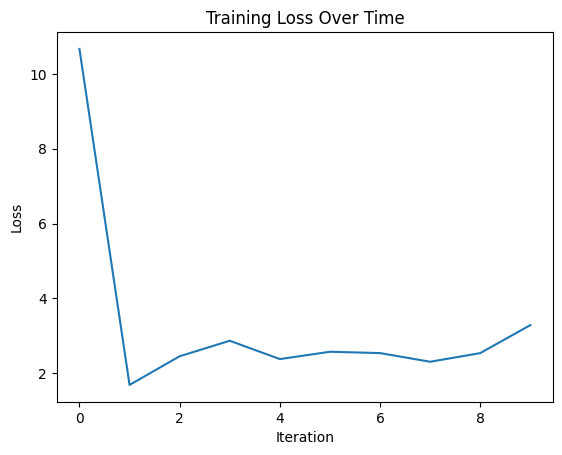

In [6]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [7]:


# Example usage of translate_sentence
sentence = "how are you today i am good?"
# sentence = " ".join([list(en_vocab.keys())[list(en_vocab.values()).index(i)] for i in en_data[4]][1:-1])
translation = translate_sentence(sentence, en_vocab, fi_vocab, encoder, decoder)
print("Translation:", " ".join(translation))

[[   1  598  253  105 7174   43  242 4211    2]]
Translation: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
sentence

'how are you today i am good?'

In [ ]:
en_data.shape, len(en_vocab)

((40, 149), 1258)